<a href="https://colab.research.google.com/github/soroushzargar/yapAIAssesment/blob/master/YapAiTek_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YapAiTek Assessment

**Assessment:** we want you to perform NLP analysis on the texts of the posts in this channel.

First step we extract clean text and remove stopmarks and useless characters.

Libraries used in this notebook:
* Pandas: For working with dataframes
* numpy: For working with numeric arrays
* nltk: For NLP purposes
* re: RegEx
* dateutil: Working with date-time data
* sklearn: Classical machine learning
* tqdm: For scrollbars in loops

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textblob
import gensim
import dateutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import wordcloud
from scipy.stats import multivariate_normal

Since the notebook and its data is stored in GoogleColab this block will access the drive directory.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Reading Data
tickerDetails = pd.read_csv(
    "/content/gdrive/My Drive/YapAiTek Assignment/result.csv"
)
telegramMessages = pd.read_csv(
    "/content/gdrive/My Drive/YapAiTek Assignment/betasahm1.csv",
    header=None
).rename(mapper={0:'time', 1:'message'}, axis=1)

# Changing dateTime column type
telegramMessages['time'] = pd.to_datetime(telegramMessages['time'])
telegramMessages = telegramMessages.sort_values('time').reset_index().drop(columns=['index'])


tickerNames = tickerDetails['symbolFA'].to_list()

# Correcting Nan Messages
telegramMessages = telegramMessages.fillna('')

# Sorting By Time


Given tables are as following:

In [5]:
# tickerDetails table
tickerDetails.head()

,ticker,symbolFA,nameFA,industryIndex,market
0,IRO1PAKS0001,شپاکسا,پاکسان‌,IREXCLEANINGPRODUCT,11.0
1,IRO1PKER0001,کرماشا,صنایع پتروشیمی کرمانشاه,IREXAGRICULTURALCHEMICALS,11.0
2,IRO1ABAD0001,ثاباد,توریستی ورفاهی آبادگران ایران,IREXCONSTRUCTION,15.0
3,IRO1ABDI0001,دعبید,لابراتوارداروسازی‌ دکترعبیدی‌,IREXPHARMACEUTICALS,15.0
4,IRO1ABIK0001,سابیک,سیمان آبیک,IREXOTHERNONMETALLICPRODUCTS,15.0


In [6]:
# telegramMessages table
telegramMessages.head()

,time,message
0,2019-01-01 05:02:58+00:00,صفوف خرید بازار جالب است های وب سپاها چکارن د...
1,2019-01-01 05:05:08+00:00,#چفیبر اقدام به فروش یک باب ویلا واقع در دهکده...
2,2019-01-01 05:14:02+00:00,بخشنامه جدید ارزی بانک مرکزی برای صادرات\nاقتص...
3,2019-01-01 05:26:48+00:00,#دارو جلسه مجمع عمومی این شرکت در ساعت 10:0...
4,2019-01-01 05:39:59+00:00,رنج های مثبت در تجارت


Some posts are having a link inside them, since we omit english characters we store these links in another database.

In [0]:
# Saving link informations in another table
linkMessages = telegramMessages.loc[
  telegramMessages['message'].str.contains('http')
]

In [8]:
linkMessages.head()

,time,message
5,2019-01-01 05:52:56+00:00,تحلیل بنیادی سیمان داراب\n\nسیمان داراب با سرم...
6,2019-01-01 05:57:34+00:00,تحلیل بنیادی سیمان صوفیان\n\nاز سال ۹۳ به بعد ...
18,2019-01-01 09:00:14+00:00,تحلیل تکنیکال چکاپا\n\nیک رشد میان مدت به بازا...
24,2019-01-01 14:15:31+00:00,گزارش بازارسه شنبه ۱۱دی۹۷\nحجم های گل کرده ! \...
33,2019-01-02 03:11:18+00:00,تحلیل تکنیکال وپاسار\n\nوپاسار پس از دوسال به ...


# Cleaning Messages
In the `telegramMessages` in addition to persian alphabet we see other characters including punctuations, newlines and english alphabet. Also there are some terms that are usual in sense of any language like verbs. These *stopwords* are given from a GitHub Repository (https://github.com/kharazi/persian-stopwords). 

At last what we get from this section is a entity-word matrix which shows number of times a word is mentioned. The result is saved in a dataframe called `corpus`.

In [0]:
# Removing Nonsense Word like Verbs or ... (stop words)
# Thanks to https://github.com/kharazi/persian-stopwords
stopwords = []
f = open("/content/gdrive/My Drive/YapAiTek Assignment/stopwords/verbal")
stopwords += f.read().split('\n')[:-1]
f = open("/content/gdrive/My Drive/YapAiTek Assignment/stopwords/short")
stopwords += f.read().split('\n')[:-1]
f = open("/content/gdrive/My Drive/YapAiTek Assignment/stopwords/persian")
stopwords += f.read().split('\n')[:-1]
f = open("/content/gdrive/My Drive/YapAiTek Assignment/stopwords/nonverbal")
stopwords += f.read().split('\n')[:-1]
f = open("/content/gdrive/My Drive/YapAiTek Assignment/stopwords/chars")
stopchars = f.read().split('\n')[:-1]

In [0]:
def cleaner(text):
  text = re.sub('\n', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('#', '', text)
  text = re.sub('ریال', '', text)
  text = re.sub('،', '', text)
  text = re.sub('«»', '', text)
  for c in range(ord('a'), ord('z') + 1):
    text = re.sub(chr(c), '', text)
  for c in range(ord('A'), ord('Z') + 1):
    text = re.sub(chr(c), '', text)
  for c in range(ord('0'), ord('9') + 1):
    text = re.sub(chr(c), '', text)
  for c in range(ord('۰'), ord('۹') + 1):
    text = re.sub(chr(c), '', text)
  # for c in stopchars:
  #   text = re.sub(c, '', text)
    
  return text

clr = lambda x: cleaner(x)

In [0]:
cleanTelegramMessages = telegramMessages
cleanTelegramMessages['message'] = cleanTelegramMessages['message'].apply(clr) 

In [12]:
cleanTelegramMessages.head()

,time,message
0,2019-01-01 05:02:58+00:00,صفوف خرید بازار جالب است های وب سپاها چکارن د...
1,2019-01-01 05:05:08+00:00,چفیبر اقدام به فروش یک باب ویلا واقع در دهکده ...
2,2019-01-01 05:14:02+00:00,بخشنامه جدید ارزی بانک مرکزی برای صادرات اقتصا...
3,2019-01-01 05:26:48+00:00,دارو جلسه مجمع عمومی این شرکت در ساعت روز ...
4,2019-01-01 05:39:59+00:00,رنج های مثبت در تجارت


In [0]:
# Vectorizaing
cv = CountVectorizer()
corpus = cv.fit_transform(cleanTelegramMessages.message)
corpus = pd.DataFrame(corpus.toarray(), columns=cv.get_feature_names())

In [0]:
# Dropping stopwords and tickernames
corpus = corpus.drop(columns=stopwords, errors='ignore')
corpus = corpus.drop(columns=tickerNames, errors='ignore')

In [15]:
corpus

,آآآ,آآآآی,آئين,آئین,آئینامه,آب,آبادان,آبادانسهامی,آبادبلواراتحادکيلومترجاده,آبادبلواردرياخيابان,آبادبندر,آبادتر,آبادميدان,آباده,آبادي,آبادگران,آبادی,آبان,آبانماه,آبانی,آبخور,آبراه,آبراهام,آبراههای,آبرسانی,آبرومند,آبرومندانه,آبروی,آبسال,آبستن,آبشار,آبشاراول,آبشارهای,آبشهيد,آبشيرين,آبعلي,آبفا,آبفر,آبمان,آبميوه,...,ﺷﺪ,ﺷﺪه,ﺷﺮﮐﺖ,ﺷﻨﺎﺳﺎﯾﯽ,ﺻﻨﺪوق,ﺻﻮرت,ﻃﯽ,ﻃﺮﯾﻖ,ﻇﺮف,ﻓﻮﻻد,ﻗﺎﻧﻮﻧﯽ,ﻣـﯿﻠﯿﺎرد,ﻣـﺒﻠﻎ,ﻣـﺤﮑﻮﻣﯿﺖ,ﻣـﻄﺎﻟﺒﺎت,ﻣـﻮﺳﺴﻪ,ﻣﮑﻠﻒ,ﻣﯿﻠﯿﺎرد,ﻣﺎ,ﻣﺎﻧﺪه,ﻣﺒﻠﻎ,ﻣﺤﺎﺳﺒﻪ,ﻣﺤﺾ,ﻣﺪت,ﻣﺮاﺣﻞ,ﻣﻄﺎﻟﺒﺎت,ﻣﻨﻮط,ﻣﻮرخ,ﻣﻮﺳﺴﻪ,ﻣﻮﺿﻮع,ﻧﭙﺬﯾﺮﻓﺖ,ﻧﺤﻮه,ﻧﺪﺍﺭﯾﻢ,ﻧﺬﺍﺭ,ﻧﺴﺒﺖ,ﻧﻤﻮد,ﻫﯿﭽﮕﻮﻧﻪ,ﻫﺎي,ﻫﺰﯾﻨﻪ,ﻻزم
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28423,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28424,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28425,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Getting Information about Tickers
First we try to get what tickers are mentioned in each post. This information is stored in a dataframe called `tickerReported`. 

In [0]:
tickerReported = cleanTelegramMessages

In [17]:
for ticker in tqdm(tickerNames):
  tickerReported[ticker] = cleanTelegramMessages['message'].str.contains(ticker)

In [18]:
tickerReported

,time,message,شپاکسا,کرماشا,ثاباد,دعبید,سابیک,والبر,فایرا,فمراد,کلوند,دامین,شاملا,کسرا,لابسا,آسیا,واتی,خاهن,پردیس,فاذر,خاذین,کبافق,فباهنر,البرز,وبوعلی,کاما,وبانک,وانصار,پکرمان,دانا,غبهنوش,خبهمن,وبیمه,ملت,وبملت,شپارس,لبوتان,وپارس,وپاسار,وپست,...,کنیلو,بخاور,کچینی,وحکمت,خعمرا,شپمچا,وپسا,سکارون,شمواد,شپلی,وآداک,وزمین,کمینا,شساخت,وملت,خفناور,غپونه,خکاوه,خکرمان,حرهور,وفتخار,جوین,خاور,وامیر,قنقش,سمایه,شفارا,کهرام,گنگین,فنفت,وگردش,شلیا,قشرین,وهنر,غبهار,ثاژن,خبازرس,شپترو,گتوشا,ورفاه
0,2019-01-01 05:02:58+00:00,صفوف خرید بازار جالب است های وب سپاها چکارن د...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2019-01-01 05:05:08+00:00,چفیبر اقدام به فروش یک باب ویلا واقع در دهکده ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2019-01-01 05:14:02+00:00,بخشنامه جدید ارزی بانک مرکزی برای صادرات اقتصا...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2019-01-01 05:26:48+00:00,دارو جلسه مجمع عمومی این شرکت در ساعت روز ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2019-01-01 05:39:59+00:00,رنج های مثبت در تجارت,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28422,2020-04-23 19:15:08+00:00,میانگین نرخ دلار در بازار ثانویه از ابتدای سال...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

Tracking the number of occurance of each word... The number of times each word is mentioned is stored in `occuranceDf` table. Since words that are mentioned more than 1000 times are limited we can find some frequent words with positive of negative meanings just by user observation.

In [19]:
words = corpus.columns.to_list()
occurance = dict.fromkeys(words)
for elem in tqdm(words):
  occurance[elem] = corpus[elem].sum()

for tickerName in tickerNames:
  occurance.pop(tickerName, None)

In [0]:
occuranceDf = pd.DataFrame.from_dict(
    {k: v for k, v in sorted(occurance.items(), key=lambda item: item[1])},
    orient='index', columns=['occurance']
)

In [0]:
# Frequent Words: Since the quantity of them is not high we can find syno's by 
#   person
downThreshold = 1000
frequentTerms = occuranceDf.loc[
    occuranceDf['occurance'] > downThreshold].reset_index()['index'].to_list()

In [22]:
print(frequentTerms)

['بنیادی', 'دارایی', 'هفته', 'اصلاح', 'ارز', 'میگردد', 'ادامه', 'خبر', 'شناسایی', 'هیئت', 'سرمايه', 'گروه', 'سهامداران', 'شنبه', 'عملکرد', 'رئیس', 'مجموعه', 'آمریکا', 'دولت', 'اوراق', 'زد', 'ارزش', 'مهم', 'منظور', 'پول', 'کار', 'برگزار', 'شرایط', 'ساعت', 'روند', 'معاملات', 'وضعیت', 'خرید', 'مثبت', 'خصوص', 'موضوع', 'کاهش', 'تحلیل', 'نفت', 'خرداد', 'کشور', 'قرار', 'سازمان', 'اردیبهشت', 'میانگین', 'شهریور', 'ثبت', 'شفاف', 'جلسه', 'تاریخ', 'تهران', 'عمومی', 'مرداد', 'اذر', 'تیر', 'توجه', 'ابان', 'محل', 'اسفند', 'درصد', 'زیان', 'نسبت', 'تومان', 'سهام', 'دلار', 'مورخ', 'عرضه', 'تولید', 'تن', 'افت', 'بهمن', 'فروردین', 'قیمت', 'بانک', 'جمع', 'مجمع', 'مشابه', 'مهر', 'مالی', 'خالص', 'مبلغ', 'درامد', 'ایران', 'نظر', 'زده', 'عملیاتی', 'محقق', 'افزایش', 'رشد', 'خوبی', 'مواجه', 'عدد', 'ماه', 'گزارش', 'سرمایه', 'سال', 'سهم', 'نرخ', 'شرکت', 'بازار', 'سود', 'ماهه', 'فروش']


In [0]:
positiveTerms = [
  'رشد',
  'خوبی',
  'مثبت',
  'سود',
  'افزایش',
  # 'محقق',
  # 'عملیاتی',
  'مثبت',
  'بهبود'
]
negativeTerms = [
  'افت',
  'مواجه',
  'منفی',
  'کاهش',
  'زیان'
]

In [24]:
qualityDf = tickerReported[['time']]
qualityDf['positive'] = corpus[positiveTerms].sum(axis=1)
qualityDf['negative'] = corpus[negativeTerms].sum(axis=1)
qualityDf = qualityDf.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
qualityDf

,index,time,positive,negative
0,0,2019-01-01 05:02:58+00:00,0,0
1,1,2019-01-01 05:05:08+00:00,0,0
2,2,2019-01-01 05:14:02+00:00,0,0
3,3,2019-01-01 05:26:48+00:00,1,0
4,4,2019-01-01 05:39:59+00:00,2,0
...,...,...,...,...
28422,28422,2020-04-23 19:15:08+00:00,1,0
28423,28423,2020-04-23 19:19:01+00:00,0,0
28424,28424,2020-04-23 19:20:10+00:00,0,0
28425,28425,2020-04-23 19:21:01+00:00,0,0


One important drowback of this procedure is that tickers are not described in same time domain. In next blocks we will cover that drowbacks. But, for now the positive and negative impact of each ticker is derived. To overcome that drawback we store indecies of mentioned tickers and use them in regression.

We perform a linear regresion on the impact data and we use the coeficient as a parameter.

**Note:** *If a ticker has a high impact on messages and have been mentioned a lot of times, it is trivial to have more positive (or negative) score than others whom are mentioned less. To overcome that issue we also calculate some factor called normalized impact.*

In [26]:
impactArrays = []
normalizedImpactArrays = []
mentionedCard = []
mentionedIndexes = []
normalizedCoeficients = []
coeficients = []

for tickerName in tqdm(tickerNames):
  pos = qualityDf.loc[tickerReported[tickerName] == True]['positive'].to_numpy()
  neg = qualityDf.loc[tickerReported[tickerName] == True]['negative'].to_numpy()
  indexes = qualityDf.loc[tickerReported[tickerName] == True]['index'].to_numpy()
  impact = np.cumsum(pos - neg)
  impactArrays.append(impact)
  mentionedCard.append(impact.shape[0])
  mentionedIndexes.append(indexes)
  normalizedImpactArrays.append(impact/impact.shape[0])

  # Fitting a Regressor to save the coef as a feature
  if indexes.shape[0] != 0:
    reg = LinearRegression()
    reg.fit(indexes.reshape((-1, 1)), impact.reshape((-1, 1)))
    coeficients.append(reg.coef_[0][0])
  else:
    coeficients.append(0)

  # Fitting a Regressor on normalized data
  if indexes.shape[0] != 0:
    reg = LinearRegression()
    reg.fit(indexes.reshape((-1, 1)), (impact/impact.shape[0]).reshape((-1, 1)))
    normalizedCoeficients.append(reg.coef_[0][0])
  else:
    normalizedCoeficients.append(0)
  
mentionedCard = np.array(mentionedCard) 

Following plots shows the normalized impact and impact (positiveness and negativeness) of the tickers data based on messages given in telegram channel over time.

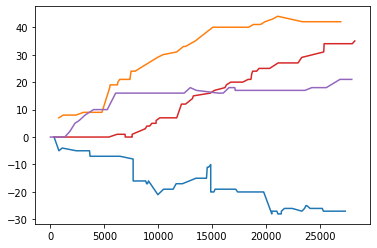

In [27]:
randVector = []
for i in range(5):
  rnd = random.randrange(len(impactArrays))
  plt.plot(mentionedIndexes[rnd], impactArrays[rnd])
  randVector.append(rnd)
plt.show()

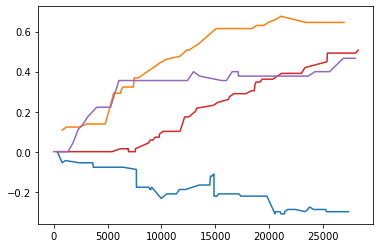

In [28]:
for i in range(5):
  rnd = randVector[i]
  plt.plot(mentionedIndexes[rnd], normalizedImpactArrays[rnd])

plt.show()

In [0]:
tickerImpacts = tickerDetails[['ticker', 'symbolFA']]

In [30]:
tickerImpacts['timesMentioned'] = mentionedCard
tickerImpacts['riseCoef'] = coeficients
tickerImpacts['normalizedCoef'] = normalizedCoeficients

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
tickerImpacts

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef
0,IRO1PAKS0001,شپاکسا,62,0.002060,3.322812e-05
1,IRO1PKER0001,کرماشا,65,0.001520,2.338619e-05
2,IRO1ABAD0001,ثاباد,17,0.000041,2.403529e-06
3,IRO1ABDI0001,دعبید,61,0.001371,2.248234e-05
4,IRO1ABIK0001,سابیک,0,0.000000,0.000000e+00
...,...,...,...,...,...
857,IRO7SJAP0001,ثاژن,18,0.000007,3.758566e-07
858,IRO7IEIP0001,خبازرس,10,0.000004,3.781748e-07
859,IRO7APTP0001,شپترو,46,0.000017,3.792601e-07
860,IRO7PSDP0001,گتوشا,1,0.000000,0.000000e+00


Tickers can be sorted based on their mentions, positive impact and normalized positive impact.

In [32]:
tickerImpacts.sort_values('timesMentioned', ascending=False)

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef
303,IRO1BVMA0001,ما,20269,0.677426,0.000033
359,IRO3BDYZ0001,دی,13066,0.373009,0.000029
305,IRO1PJMZ0001,جم,8943,0.219541,0.000025
312,IRO1BORS0001,بورس,2634,0.090814,0.000034
327,IRO1SHFA0001,شفا,2010,0.035958,0.000018
...,...,...,...,...,...
517,IRO3Z0130001,پتروشیمی دماوند,0,0.000000,0.000000
513,IRO3Z0100001,مسکن ایران,0,0.000000,0.000000
511,IRO3Z0090001,فولاد تربت,0,0.000000,0.000000
509,IRO3Z0080001,کاغذ مراغه,0,0.000000,0.000000


In [33]:
tickerImpacts.sort_values('normalizedCoef', ascending=False)

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef
704,IRO7IRNP0001,سایرا,2,0.002212,0.001106
820,IRO7SEIP0001,وبرق,3,0.002185,0.000728
801,IRO7VMHP0001,ومهر,5,0.001175,0.000235
856,IRO7GKHP0001,غبهار,4,0.000692,0.000173
604,IRO3Z0520001,کرمان خودرو,9,0.001541,0.000171
...,...,...,...,...,...
829,IRO7KACP0001,سکارون,5,-0.000386,-0.000077
486,IRO3ZF890001,نوسازی صنایع,2,-0.000191,-0.000095
797,IRO7KAFP0001,شکف,3,-0.000329,-0.000110
707,IRO7JSHP0001,فجوش,3,-0.000528,-0.000176


Just to show how different tickers behave...

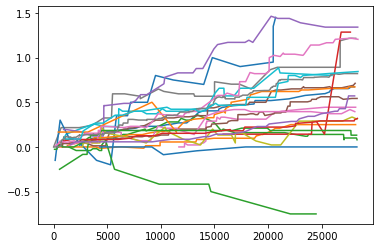

In [34]:
randVector = []
for i in range(30):
  rnd = random.randrange(len(normalizedImpactArrays))
  plt.plot(mentionedIndexes[rnd], normalizedImpactArrays[rnd])
  randVector.append(rnd)
plt.show()

### Some Visualizations and Removing Unreliable Data
In this block we use details from `tickerImpact` table to see whether we can do some sort of clustering on tickers or not... . The result is no, but the visualization is worth mentioning. 

In the visualizations it is clear that you can not trust the data from some elements. As a result we use some Mutivariate Guassian model to check what elements are not reliable.

In [0]:
x = tickerImpacts[['timesMentioned', 'riseCoef', 'normalizedCoef']]

In [0]:
norm = MinMaxScaler()
x = norm.fit_transform(x)

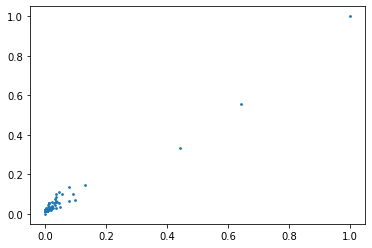

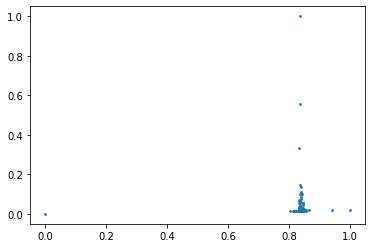

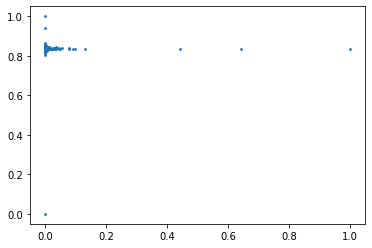

In [37]:
plt.scatter(x[:,0], x[:,1], s=3)
plt.show()


plt.scatter(x[:,2], x[:,1], s=3)
plt.show()

plt.scatter(x[:,0], x[:,2], s=3)
plt.show()

In [0]:
x_mean = np.mean(x,axis=0)
x_cov = np.cov(x.transpose())
prob = multivariate_normal(mean=x_mean, cov = x_cov)

In [0]:
tickerImpacts['pdf'] = prob.pdf(x)

In [74]:
tickerImpacts.sort_values('pdf')[:30]

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef,pdf
537,IRO3Z0290001,نفت قشم,2,-0.010870,-0.005435,3.366488e-170
303,IRO1BVMA0001,ما,20269,0.677426,0.000033,4.647914e-130
305,IRO1PJMZ0001,جم,8943,0.219541,0.000025,1.322107e-59
359,IRO3BDYZ0001,دی,13066,0.373009,0.000029,2.709499e-57
364,IRO3BMDZ0001,ودی,1558,0.083783,0.000054,1.494878e-11
49,IRO1DADE0001,مداران,922,0.064150,0.000070,2.428827e-11
319,IRO1OMID0001,امید,706,0.057032,0.000081,5.986567e-11
327,IRO1SHFA0001,شفا,2010,0.035958,0.000018,4.606653e-06
403,IRO3ZF080001,هما,730,0.048900,0.000067,9.399334e-05
330,IRO1SEPK0001,سپ,1114,0.059647,0.000054,3.365759e-04


In [0]:
prob_threshold = 1e2
unreliableTickers = tickerImpacts.loc[
  tickerImpacts['pdf'] < prob_threshold]['symbolFA'].to_list()
unreliableIndexes = tickerImpacts.loc[
  tickerImpacts['pdf'] < prob_threshold].index

In [79]:
unreliableTickers

['مداران',
 'همراه',
 'فارس',
 'ما',
 'جم',
 'بورس',
 'امید',
 'پرداخت',
 'شفا',
 'سپ',
 'پارس',
 'افرا',
 'دی',
 'ودی',
 'نکا',
 'هما',
 'نفت قشم',
 'سپرده',
 'فرابورس',
 'سپرده',
 'سایرا',
 'وبرق']

In [82]:
unreliableIndexes

Int64Index([ 49, 101, 188, 303, 305, 312, 319, 320, 327, 330, 334, 356, 359,
            364, 401, 403, 537, 589, 651, 656, 704, 820],
           dtype='int64')

In [0]:
tickerImpacts = tickerImpacts.drop(index=unreliableIndexes)

As a result the most positive impacts in the messages belongs to following table:

In [93]:
topTickers = tickerImpacts.sort_values('normalizedCoef', ascending=False);topTickers

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef,pdf
801,IRO7VMHP0001,ومهر,5,0.001175,0.000235,3966.008503
856,IRO7GKHP0001,غبهار,4,0.000692,0.000173,5474.103390
604,IRO3Z0520001,کرمان خودرو,9,0.001541,0.000171,5400.207844
805,IRO7PBRP0001,گپارس,3,0.000449,0.000150,6007.976561
642,IRO3Z0620001,باران,21,0.002868,0.000137,5676.770764
...,...,...,...,...,...,...
796,IRO7KFRP0001,کفرآور,8,-0.000544,-0.000068,7000.044863
829,IRO7KACP0001,سکارون,5,-0.000386,-0.000077,6881.601298
486,IRO3ZF890001,نوسازی صنایع,2,-0.000191,-0.000095,6545.922816
797,IRO7KAFP0001,شکف,3,-0.000329,-0.000110,6264.436399


#### Top words

First of all for this part we will omit the tickers whom are mentioned in less than a reasonable number of messages

In [0]:
mentionedLowerBound = 20
nonFrequentTickers = tickerImpacts.loc[
  tickerImpacts['timesMentioned'] < mentionedLowerBound
]

frequentTickers = tickerImpacts.loc[
  tickerImpacts['timesMentioned'] > mentionedLowerBound
]

In [87]:
corpus.sum().sort_values()[-50:].index

Index(['اذر', 'تیر', 'توجه', 'ابان', 'محل', 'اسفند', 'درصد', 'زیان', 'نسبت',
       'تومان', 'سهام', 'دلار', 'مورخ', 'عرضه', 'تولید', 'تن', 'افت', 'بهمن',
       'فروردین', 'قیمت', 'بانک', 'جمع', 'مجمع', 'مشابه', 'مهر', 'مالی',
       'خالص', 'مبلغ', 'درامد', 'ایران', 'نظر', 'زده', 'عملیاتی', 'محقق',
       'افزایش', 'رشد', 'خوبی', 'مواجه', 'عدد', 'ماه', 'گزارش', 'سرمایه',
       'سال', 'سهم', 'نرخ', 'شرکت', 'بازار', 'سود', 'ماهه', 'فروش'],
      dtype='object')

In [0]:
removables = ['اذر', 'تیر', 'توجه', 'ابان', 'محل', 'اسفند', 'درصد', 'نسبت',
       'تومان', 'سهام', 'دلار', 'مورخ', 'تن', 'بهمن',
       'فروردین', 'قیمت', 'بانک', 'جمع', 'مجمع', 'مشابه', 'مهر', 'مالی',
       'خالص', 'مبلغ', 'درامد', 'ایران', 'نظر', 'زده', 'محقق',
      'مواجه', 'عدد', 'ماه', 'گزارش', 'سرمایه',
       'سال', 'سهم', 'نرخ', 'شرکت', 'بازار', 'ماهه']

In [0]:
corpus = corpus.drop(columns=removables, errors='ignore')
corpus = corpus.drop(columns=tickerNames, errors='ignore')

In [0]:
sampleTickers = frequentTickers.sample(20)['symbolFA'].to_list()
sampleFrequentWords = []
for ticker in sampleTickers:
  sampleFrequentWords.append(
      corpus.loc[
        tickerReported[ticker] == True
      ].sum().sort_values()[-20:].index.to_list())

In [0]:
def MaxWords(ticker):
  return corpus.loc[
        tickerReported[ticker] == True
    ].sum().sort_values()[-20:].index.to_list()

In [0]:
topTickers['words'] = topTickers['symbolFA'].apply(lambda x:MaxWords(x))
timesMentionedThreshold = topTickers['timesMentioned'].mean()

Since we want to guarantee the result, we search for those whom are mentioned more than average, so the dataframe below is the final dataframe.

In [103]:
finalDataFrame = topTickers.loc[
  topTickers['timesMentioned'] > timesMentionedThreshold];finalDataFrame

,ticker,symbolFA,timesMentioned,riseCoef,normalizedCoef,pdf,words
362,IRO3BLSZ0001,بالاس,78,0.008371,0.000107,2835.331893,"[سرعت, سمت, دسته, نکته, روزها, دست, مثبت, بنیا..."
192,IRO1PNTB0001,شبریز,73,0.005146,0.000070,6008.836276,"[برگزار, اندوخته, سرمايه, اجرای, گروه, روغن, م..."
191,IRO1PNES0001,شپنا,86,0.005815,0.000068,5786.790595,"[افزایش, پرتقاضا, سیاسی, پرتفوی, مثبت, نکته, ب..."
54,IRO1DFRB0001,دفارا,76,0.005027,0.000066,6225.509762,"[ژلاتین, تحولات, سیاسی, شناسایی, کمک, متحول, ش..."
498,IRO3KSPZ0001,کاسپین,56,0.003552,0.000063,6886.478411,"[چوب, تولید, شفاف, دارویی, شهریور, زد, پتروشیم..."
...,...,...,...,...,...,...,...
564,IRO3KAHZ0001,بکهنوج,78,-0.000273,-0.000003,6511.232968,"[واذر, ارز, تولید, کهنوج, وب, خوبی, شاخص, تضمی..."
105,IRO1IAGM0001,مرقام,79,-0.000277,-0.000004,6479.968215,"[منظم, درهاور, سازمانی, تهران, عمومی, ارائه, ب..."
194,IRO1PSER0001,کسرام,74,-0.000576,-0.000008,6346.613128,"[افت, غپاذر, فروشی, اردیبهشت, خریدبازار, واوا,..."
187,IRO1PKOD0001,خپارس,90,-0.000965,-0.000011,5474.698461,"[ماده, واوا, زد, طیف, فروخته, پر, تقاضا, رنو, ..."


The visualization below shows the result of plots of top 10 and bottom 10 of the final dataframe.

In [0]:
toPlotIndexes = np.concatenate(
    [finalDataFrame.index[:10], finalDataFrame.index[-10:]])

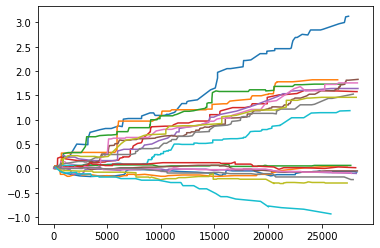

In [112]:
for index in toPlotIndexes:
  plt.plot(mentionedIndexes[index], normalizedImpactArrays[index])
plt.show()